<a href="https://colab.research.google.com/github/DJamesWilliamson/fastai/blob/master/Copy_of_lesson_1_export_jit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# fast.ai lesson 1 - training on Notebook Instance and export to torch.jit model

## Overview
This notebook shows how to use the SageMaker Python SDK to train your fast.ai model on a SageMaker notebook instance then export it as a torch.jit model to be used for inference on AWS Lambda.

## Set up the environment

You will need a Jupyter notebook with the `boto3` and `fastai` libraries installed. You can do this with the command `pip install boto3 fastai`

This notebook was created and tested on a single ml.p3.2xlarge notebook instance. 


In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
pip install boto3 fastai

## Train your model

We are going to train a fast.ai model as per [Lesson 1 of the fast.ai MOOC course](https://course.fast.ai/videos/?lesson=1) locally on the SageMaker Notebook instance. We will then save the model weights and upload them to S3.



In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import os
import io
import tarfile

import PIL

import boto3

from fastai.vision import *

In [5]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [6]:
path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [8]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

In [0]:
path_anno = path/'annotations'
path_img = path/'images'
fnames = get_image_files(path_img)
np.random.seed(2)
pat = re.compile(r'/([^/]+)_\d+.jpg$')

In [10]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/english_setter_61.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/basset_hound_111.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_7.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_222.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_67.jpg')]

In [0]:
bs=64
img_size=299

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=img_size, bs=bs//2).normalize(imagenet_stats)

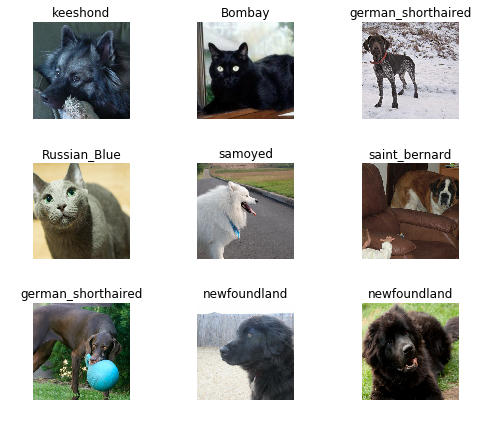

In [13]:
data.show_batch(rows=3, figsize=(7,6))

In [19]:
print(data.classes)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [18]:
len(data.classes), data.c

(37, 37)

In [20]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:04<00:00, 25137696.43it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


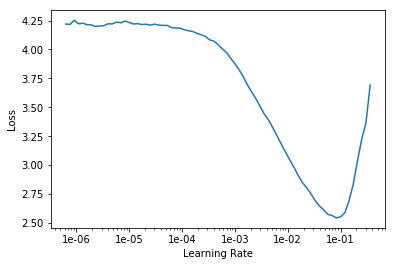

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.748320,0.256928,0.070365,03:25
1,0.438526,0.211873,0.061570,03:19
2,0.353717,0.187022,0.055480,03:19
3,0.249777,0.177356,0.051421,03:19
4,0.209064,0.152876,0.044655,03:19
5,0.144255,0.155283,0.047361,03:21
6,0.110775,0.142052,0.040595,03:18
7,0.103632,0.143992,0.042625,03:19


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

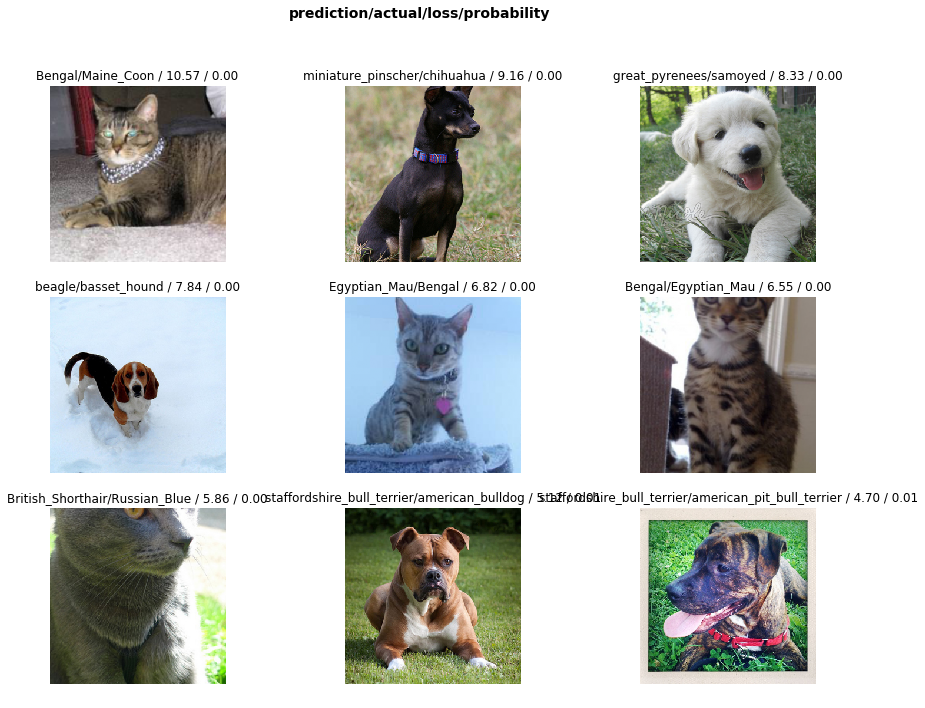

In [24]:
interp.plot_top_losses(9, figsize=(15,11))

In [25]:
help(interp.plot_top_losses)

Help on method _cl_int_plot_top_losses in module fastai.vision.learner:

_cl_int_plot_top_losses(k, largest=True, figsize=(12, 12), heatmap:bool=False, heatmap_thresh:int=16, return_fig:bool=None) -> Union[matplotlib.figure.Figure, NoneType] method of fastai.train.ClassificationInterpretation instance
    Show images in `top_losses` along with their prediction, actual, loss, and probability of actual class.



In [26]:
doc(interp.plot_top_losses)

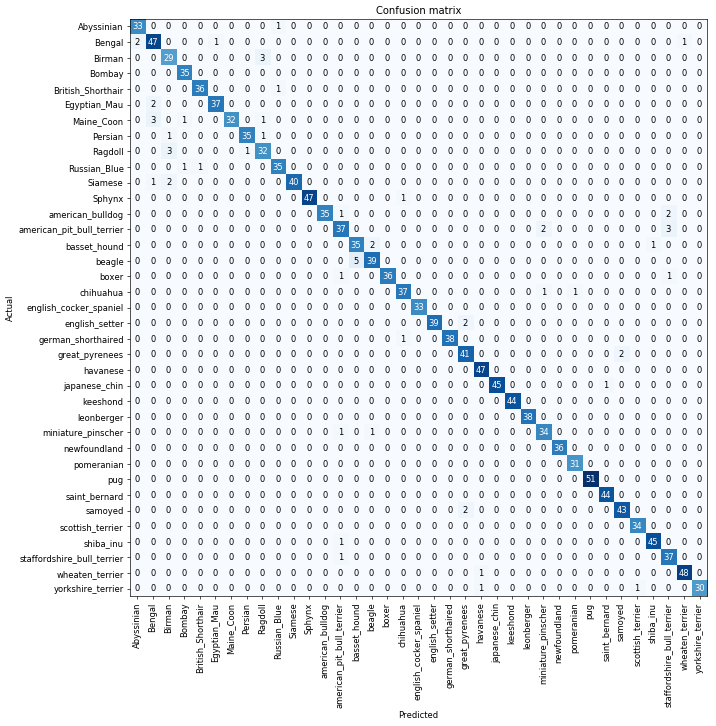

In [27]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [28]:
interp.most_confused(min_val=2)

[('beagle', 'basset_hound', 5),
 ('Birman', 'Ragdoll', 3),
 ('Maine_Coon', 'Bengal', 3),
 ('Ragdoll', 'Birman', 3),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 3),
 ('Bengal', 'Abyssinian', 2),
 ('Egyptian_Mau', 'Bengal', 2),
 ('Siamese', 'Birman', 2),
 ('american_bulldog', 'staffordshire_bull_terrier', 2),
 ('american_pit_bull_terrier', 'miniature_pinscher', 2),
 ('basset_hound', 'beagle', 2),
 ('english_setter', 'great_pyrenees', 2),
 ('great_pyrenees', 'samoyed', 2),
 ('samoyed', 'great_pyrenees', 2)]

In [0]:
learn.save('stage_1')

In [31]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.104469,0.148779,0.041949,04:26
1,0.100934,0.137432,0.038566,04:18
2,0.070394,0.138140,0.040595,04:18


In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


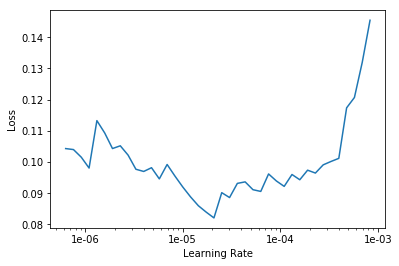

In [33]:
learn.recorder.plot()

In [34]:
learn.load('stage_1')

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
english_setter,basset_hound,scottish_terrier,english_setter,saint_bernard
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
pug,beagle,newfoundland,saint_bernard,Sphynx
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


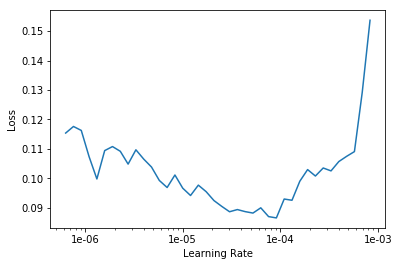

In [36]:
learn.recorder.plot()

## Export model and upload to S3

Now that we have trained our model we need to export it, create a tarball of the artefacts and upload to S3.


First we need to export the class names from the data object into a text file.

In [0]:
save_texts(path_img/'models/classes.txt', data.classes)

Now we need to export the model in the [PyTorch TorchScript format](https://pytorch.org/docs/stable/jit.html) so we can load into an AWS Lambda function.

In [0]:
trace_input = torch.ones(1,3,img_size,img_size).cuda()
jit_model = torch.jit.trace(learn.model.float(), trace_input)
model_file='resnet50_jit.pth'
output_path = str(path_img/f'models/{model_file}')
torch.jit.save(jit_model, output_path)

Next step is to create a tarfile of the exported classes file and model weights.

In [0]:
tar_file=path_img/'models/model.tar.gz'
classes_file='classes.txt'

In [0]:
with tarfile.open(tar_file, 'w:gz') as f:
    f.add(path_img/f'models/{model_file}', arcname=model_file)
    f.add(path_img/f'models/{classes_file}', arcname=classes_file)

Now we need to upload the model tarball to S3.

In [0]:
s3 = boto3.resource('s3')
s3.meta.client.upload_file(str(tar_file), 'REPLACE_WITH_YOUR_BUCKET_NAME', 'fastai-models/lesson1/model.tar.gz')